In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # prevent TensorFlow from wasting time checking for CUDA drivers

import sys
import subprocess
import importlib.util

PKG_DIR = "./python_packages" 
os.makedirs(PKG_DIR, exist_ok=True)

if PKG_DIR not in sys.path:
    sys.path.append(PKG_DIR)

def is_installed(pkg_name):
    return importlib.util.find_spec(pkg_name) is not None

# Install packages to that directory using pip
def install_package(pkg_name):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--target", PKG_DIR, pkg_name])

required_packages = ["numpy", "pandas", "matplotlib", "uproot", "scikit-learn", "seaborn", "xgboost"]
for pkg in required_packages:
    if not is_installed(pkg):
        print(f"Installing {pkg}...")
        install_package(pkg)
    else:
        print(f"{pkg} already installed.")

numpy already installed.
pandas already installed.
matplotlib already installed.
uproot already installed.
Installing scikit-learn...
  Using cached scikit_learn-1.6.1-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached numpy-2.2.5-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.5.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.2 MB)
Using cached joblib-1.5.0-py3-none-any.whl (307 kB)
Using cached numpy-2.2.5-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.1 MB)
Using cached scipy-1.15.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.3 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


seaborn already installed.
xgboost already installed.


In [2]:
from Tools.PlotTools import *

import math
import random

import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from matplotlib import rcParams
rcParams['figure.constrained_layout.use'] = True
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True
import seaborn as sns

import pandas as pd
import uproot

Loading .rootlogon.C
Loading sPhenixStyle.C
sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode
Loading paul_tol_colors.hpp
Loading RooDoubleCB.cxx


In [3]:
def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False

In [4]:
if in_ipynb():
    print("In IPython")
    import Configs.TrainConfig as Conf
    importlib.reload(Conf)  # Force reload in case file was updated
    TrainConfig = "Configs/TrainConfig"
else:
    print("Not in IPython")
    TrainConfig = sys.argv[1]
    print(f"Importing settings from {TrainConfig.replace('/', '.')}")
    import importlib.util
    import_path = TrainConfig.replace("/", ".")
    Conf = importlib.import_module(import_path)
    importlib.reload(Conf)

# Set defaults if not defined in the config
if not hasattr(Conf, 'RandomState'): Conf.RandomState = 42
if not hasattr(Conf, 'MVAlogplot'):  Conf.MVAlogplot = False
if not hasattr(Conf, 'Multicore'):   Conf.Multicore = False

# Make output directory to store configuration, trainer, and training results
prGreen("Making output directory: {}".format(Conf.OutputDirName))
os.system("mkdir -p " + Conf.OutputDirName)
os.system("mkdir -p " + Conf.OutputDirName+"/Trainer-Config")
os.system("mkdir -p " + Conf.OutputDirName+"/Thresholds")
os.system("cp "+TrainConfig+".py ./"+ Conf.OutputDirName+"/Trainer-Config/")

if in_ipynb():
    os.system("cp Trainer.ipynb ./"+ Conf.OutputDirName+"/Trainer-Config/")
else:
    os.system("cp Trainer.py ./"+ Conf.OutputDirName+"/Trainer-Config/")

if len(Conf.MVAs)>0:
    for MVAd in Conf.MVAs:
        os.system("mkdir -p " + Conf.OutputDirName+"/"+MVAd)

{'IPKernelApp': {'connection_file': '/direct/sphenix+u/hjheng/.local/share/jupyter/runtime/kernel-a7aae2c3-169d-4ccb-aed1-e1bb7051d82f.json'}}
In IPython
 Making output directory: ./Output_TEST
{'IPKernelApp': {'connection_file': '/direct/sphenix+u/hjheng/.local/share/jupyter/runtime/kernel-a7aae2c3-169d-4ccb-aed1-e1bb7051d82f.json'}}


In [5]:
if Conf.Debug==True:
    prGreen("Running in debug mode: Only every 10th event will be used")
else:
    prGreen("Running in non-debug mode")

 Running in non-debug mode


In [6]:
prGreen("Making data frames")
df_signal = pd.DataFrame()
df_background = pd.DataFrame()

# dataframe of signal
for SigFile, SigWt, SigCut in zip(Conf.SignalNtuplesFiles, Conf.SignalWeights, Conf.SignalCuts):
    print("File:{}\nWeight:{}\nCut:{}\n".format(SigFile, SigWt, SigCut))
    sig_i = uproot.open("{}:{}".format(SigFile,Conf.SignalTree))
    
    # If the string is empty, the weight is set to 1
    if SigWt == "":
        df_sig_i = sig_i.arrays(Conf.Branches, library="pd")
        df_sig_i["weight"]=1.0
    else:
        branches = Conf.Branches + [SigWt]
        df_sig_i = sig_i.arrays(branches, library="pd")
        df_sig_i = df_sig_i.rename(columns={f"{SigWt}": "weight"})

    df_signal=pd.concat([df_signal,df_sig_i],ignore_index=True, sort=False)

# dataframe of background
for BkgFile, BkgWt, BkgCut in zip(Conf.BkgNtuplesFiles, Conf.BkgWeights, Conf.BkgCuts):
    print("File:{}\nWeight:{}\nCut:{}\n".format(BkgFile, BkgWt, BkgCut))
    bkg_i = uproot.open("{}:{}".format(BkgFile,Conf.BkgTree))
    
    # If the string is empty, the weight is set to 1
    if BkgWt == "":
        df_bkg_i = bkg_i.arrays(Conf.Branches, library="pd")
        df_bkg_i["weight"]=1.0
    else:
        branches = Conf.Branches + [BkgWt]
        df_bkg_i = bkg_i.arrays(branches, library="pd")
        df_bkg_i = df_bkg_i.rename(columns={f"{BkgWt}": "weight"})

    df_background=pd.concat([df_background,df_bkg_i],ignore_index=True, sort=False)

 Making data frames
File:/sphenix/user/aopatton/D0Reco/SimulationKSReco/DATA/outputKFParticle_pipi_reco_20250513_3D_weightedTest.root
Weight:
Cut:

File:/sphenix/user/aopatton/D0Reco/SimulationKSReco/DATA/looseCuts_onlyTriggerweightedTest_sWeighted.root
Weight:
Cut:K_S0_mass<=0.45||K_S0_mass>=0.53



In [7]:
df_signal.head()

,K_S0_DIRA,K_S0_decayLength,K_S0_decayLengthErr,track_1_IP_xy,track_2_IP_xy,K_S0_SV_chi2_per_nDoF,K_S0_chi2,track_1_pT,track_2_pT,track_1_pseudorapidity,track_2_pseudorapidity,track_1_phi,track_2_phi,weight
0,0.998506,5.632285,0.207304,3.031749,-3.193990,0.521330,1.735673,0.289144,0.257066,0.640173,0.654073,-0.601398,1.086975,1.0
1,0.999675,2.473175,0.210113,-0.344654,0.408402,-0.000072,0.552522,0.689922,0.728589,0.276925,0.727668,3.041485,2.682203,1.0
2,0.999581,3.535844,0.249101,-0.794676,1.037422,0.210227,0.714192,0.854065,0.548361,0.472168,0.323229,2.864274,2.276748,1.0
3,0.996862,4.326836,0.264067,-1.254470,2.434513,0.021482,0.134838,0.705663,0.244273,0.033302,0.122813,-0.321799,-1.256091,1.0
4,0.999456,3.615499,0.190417,0.666118,-1.768156,0.599268,3.343841,0.916108,0.405810,-0.117135,-0.074235,1.823101,2.502589,1.0


In [8]:
df_background.head()

,K_S0_DIRA,K_S0_decayLength,K_S0_decayLengthErr,track_1_IP_xy,track_2_IP_xy,K_S0_SV_chi2_per_nDoF,K_S0_chi2,track_1_pT,track_2_pT,track_1_pseudorapidity,track_2_pseudorapidity,track_1_phi,track_2_phi,weight
0,0.988569,0.068434,0.005256,-0.015079,0.010504,1.049072,18.232777,0.234473,1.021958,0.000000,-0.496465,1.990958,1.481318,1.0
1,0.935462,0.613356,0.187351,-0.018118,0.381601,38.293533,11.937194,0.363589,0.398737,-0.671343,-0.434511,0.458330,-0.335712,1.0
2,0.913098,1.536713,0.203386,-1.261063,-0.016005,0.009766,3.503860,0.296537,0.395588,0.489337,0.781987,-0.833474,-2.163461,1.0
3,0.893439,1.364095,0.264267,0.493124,0.028454,0.177713,-0.150509,0.366346,0.375048,-0.752163,0.068892,1.345339,1.638934,1.0
4,0.931149,0.274496,0.131841,0.010018,-0.109709,0.224331,2.881388,0.202799,1.572042,0.704640,0.921213,0.089284,0.626737,1.0


In [9]:
df_signal[Conf.Category]=1
df_background[Conf.Category]=0

df_signal["Class"]="Signal"
df_background["Class"]="Background"

df_final=pd.concat([df_signal,df_background],ignore_index=True, sort=False)

df_final.head()

,K_S0_DIRA,K_S0_decayLength,K_S0_decayLengthErr,track_1_IP_xy,track_2_IP_xy,K_S0_SV_chi2_per_nDoF,K_S0_chi2,track_1_pT,track_2_pT,track_1_pseudorapidity,track_2_pseudorapidity,track_1_phi,track_2_phi,weight,category,Class
0,0.998506,5.632285,0.207304,3.031749,-3.193990,0.521330,1.735673,0.289144,0.257066,0.640173,0.654073,-0.601398,1.086975,1.0,1,Signal
1,0.999675,2.473175,0.210113,-0.344654,0.408402,-0.000072,0.552522,0.689922,0.728589,0.276925,0.727668,3.041485,2.682203,1.0,1,Signal
2,0.999581,3.535844,0.249101,-0.794676,1.037422,0.210227,0.714192,0.854065,0.548361,0.472168,0.323229,2.864274,2.276748,1.0,1,Signal
3,0.996862,4.326836,0.264067,-1.254470,2.434513,0.021482,0.134838,0.705663,0.244273,0.033302,0.122813,-0.321799,-1.256091,1.0,1,Signal
4,0.999456,3.615499,0.190417,0.666118,-1.768156,0.599268,3.343841,0.916108,0.405810,-0.117135,-0.074235,1.823101,2.502589,1.0,1,Signal


In [10]:
from sklearn.model_selection import train_test_split
TrainIndices, TestIndices = train_test_split(df_final.index.values.tolist(), test_size=Conf.TestSize, random_state=Conf.RandomState, shuffle=True)

df_final.loc[TrainIndices,'Dataset'] = "Train"
df_final.loc[TestIndices,'Dataset'] = "Test"

df_final.loc[TrainIndices,'TrainDataset'] = 1
df_final.loc[TestIndices,'TrainDataset'] = 0

/tmp/ipykernel_2532269/3654142783.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


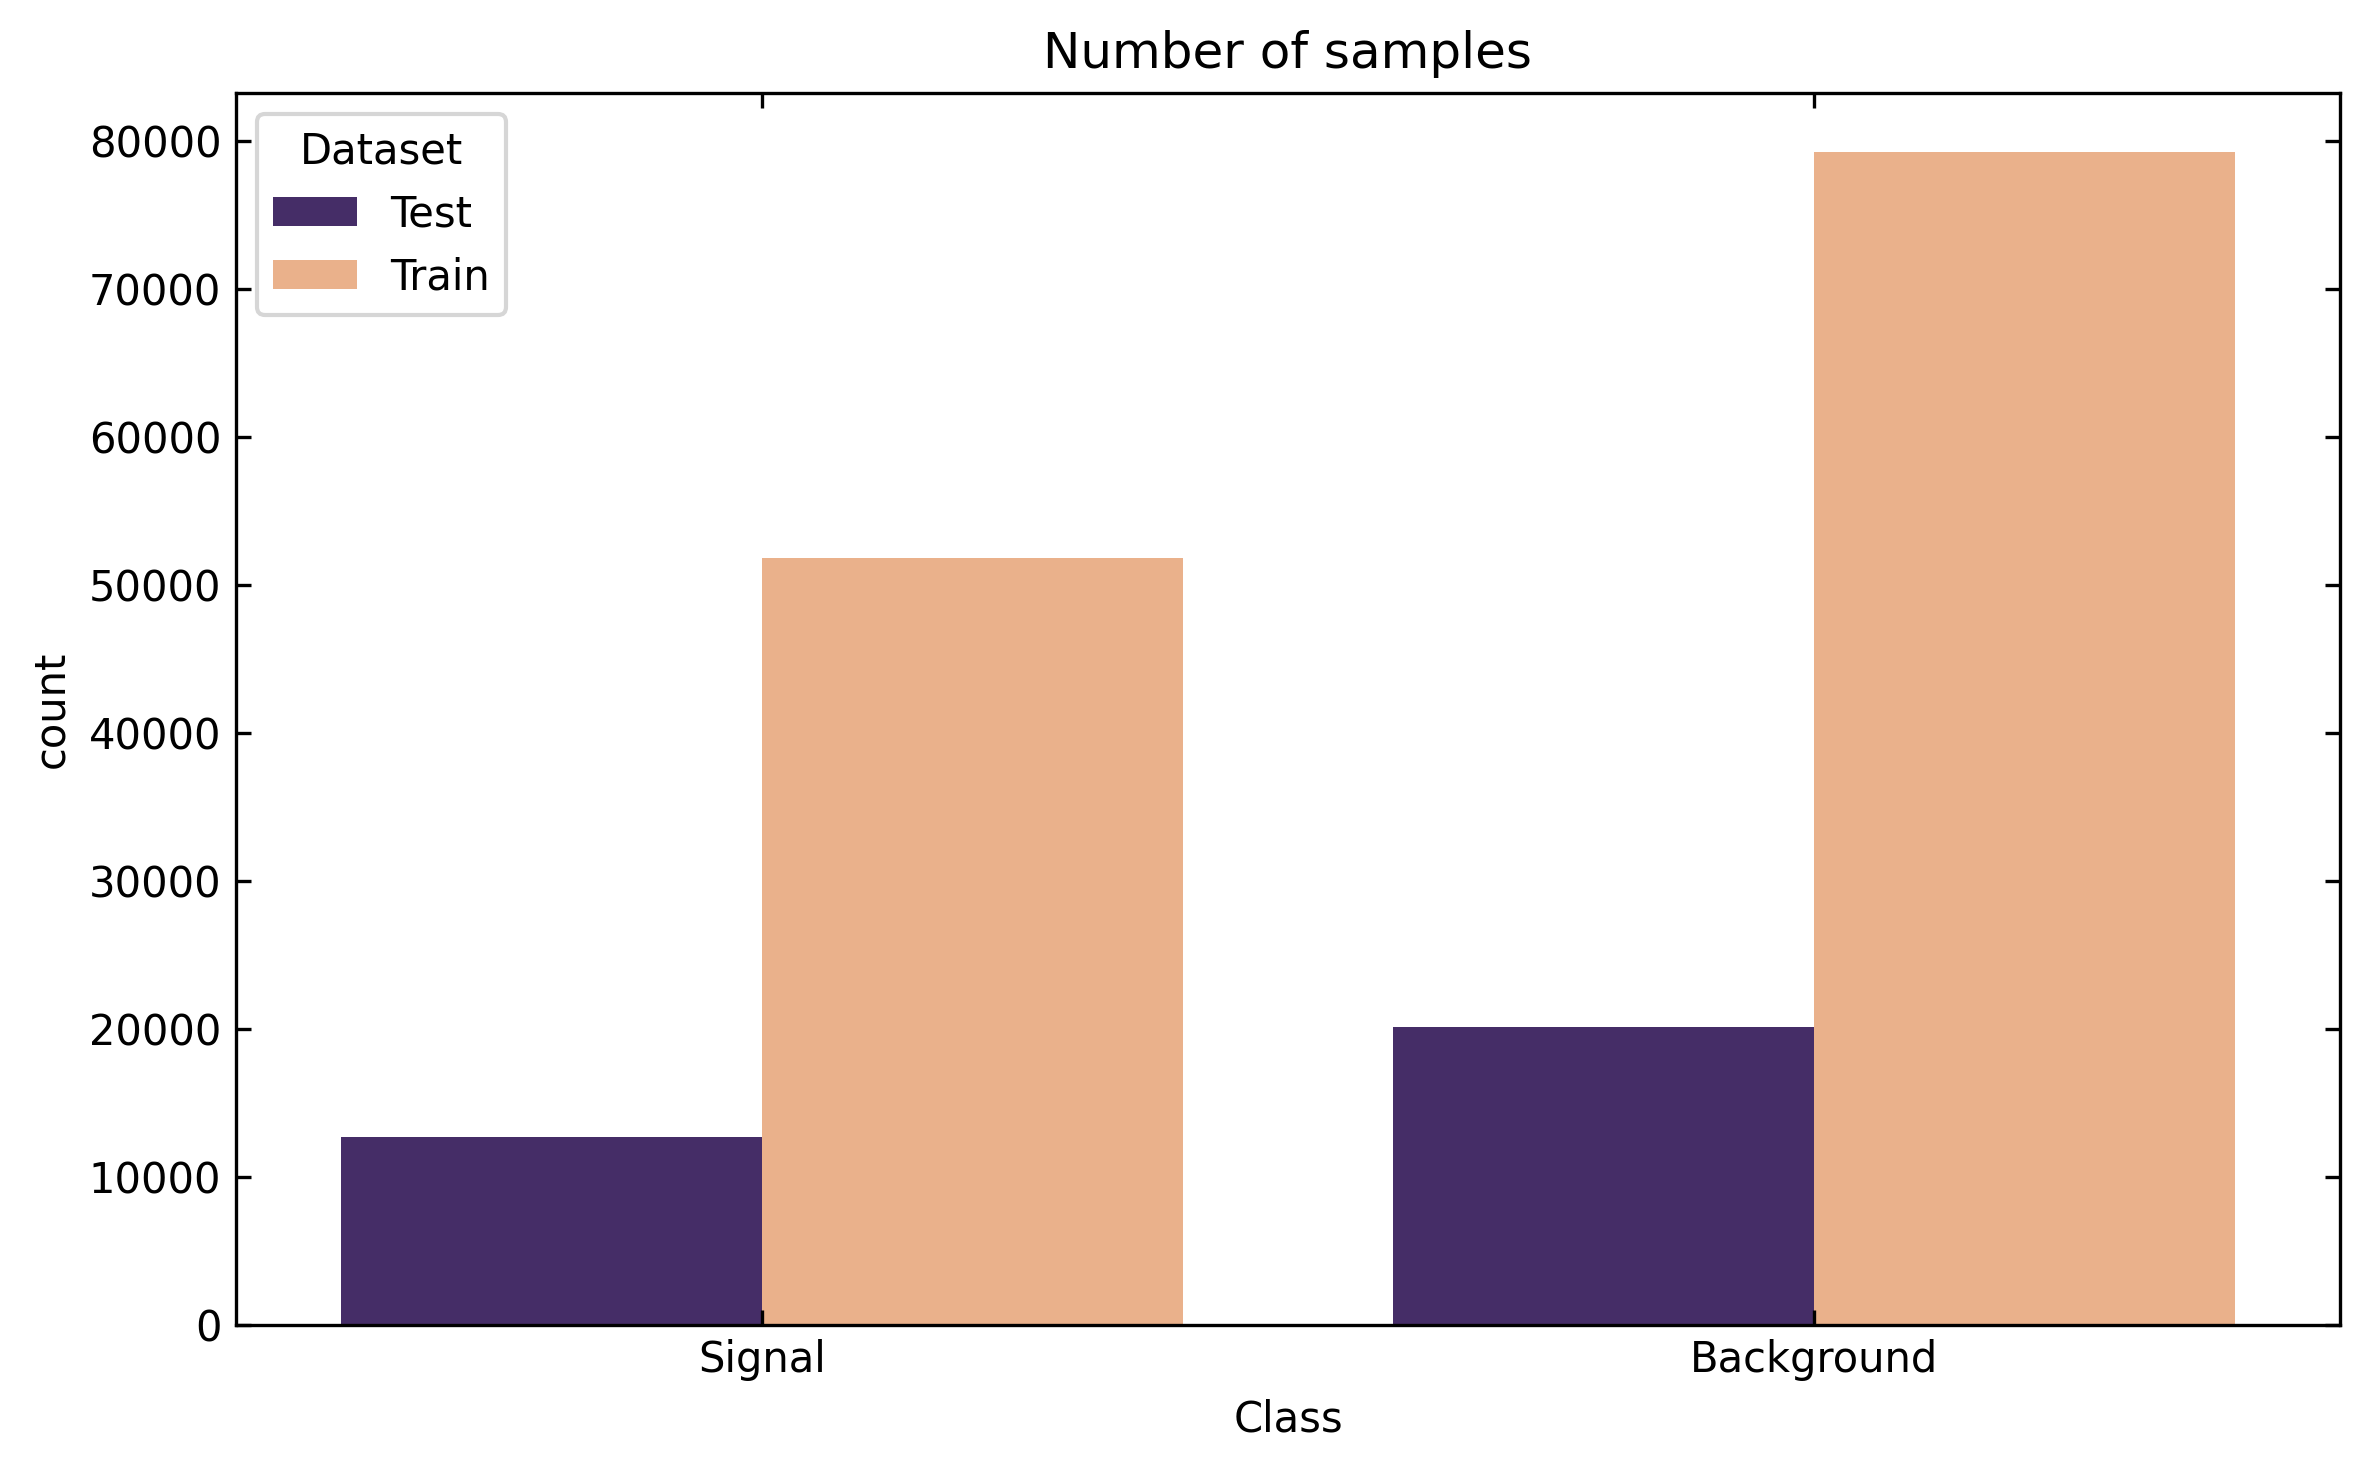

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
sns.countplot(x="Class", data=df_final, ax=axes, hue='Dataset', palette=['#432371',"#FAAE7B"])
axes.set_title("Number of samples")
#axes.set_yscale("log")
plt.tight_layout()
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.pdf")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.png")

In [12]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]
    
    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]

    X_train = np.asarray(X_train)
    Y_train = np.asarray(Y_train)
    Wt_train = np.asarray(Wt_train)
    
    X_test = np.asarray(X_test)
    Y_test = np.asarray(Y_test)
    Wt_test = np.asarray(Wt_test)
    return X_train, Y_train, Wt_train, X_test, Y_test, Wt_test

 Making Train dataset feature plots with ROOT
 XGB_1 Training starting
 Performing XGB grid search
Fitting 3 folds for each of 1 candidates, totalling 3 fits
 Expected neg log loss of XGB model = -31.7%
 Expected accuracy of XGB model = -31.68706729607945%
 XGB Best Parameters
 {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 500, 'scale_pos_weight': 1}
 Plotting output response for XGB


/tmp/ipykernel_2532269/2567816281.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


 Plotting ROC for XGB


/tmp/ipykernel_2532269/2567816281.py:61: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Info in <TCanvas::Print>: pdf file ./Output_TEST/XGB_1/Features/feature_K_S0_DIRA_Train.pdf has been created
Info in <TCanvas::Print>: png file ./Output_TEST/XGB_1/Features/feature_K_S0_DIRA_Train.png has been created
Info in <TCanvas::Print>: pdf file ./Output_TEST/XGB_1/Features/feature_K_S0_decayLength_Train.pdf has been created
Info in <TCanvas::Print>: png file ./Output_TEST/XGB_1/Features/feature_K_S0_decayLength_Train.png has been created
Info in <TCanvas::Print>: pdf file ./Output_TEST/XGB_1/Features/feature_K_S0_decayLengthErr_Train.pdf has been created
Info in <TCanvas::Print>: png file ./Output_TEST/XGB_1/Features/feature_K_S0_decayLengthErr_Train.png has been created
Info in <TCanvas::Print>: pdf file ./Output_TEST/XGB_1/Features/feature_track_1_IP_xy_Train.pdf has been created
Info in <TCanvas::Print>: png file ./Output_TEST/XGB_1/Features/feature_track_1_IP_xy

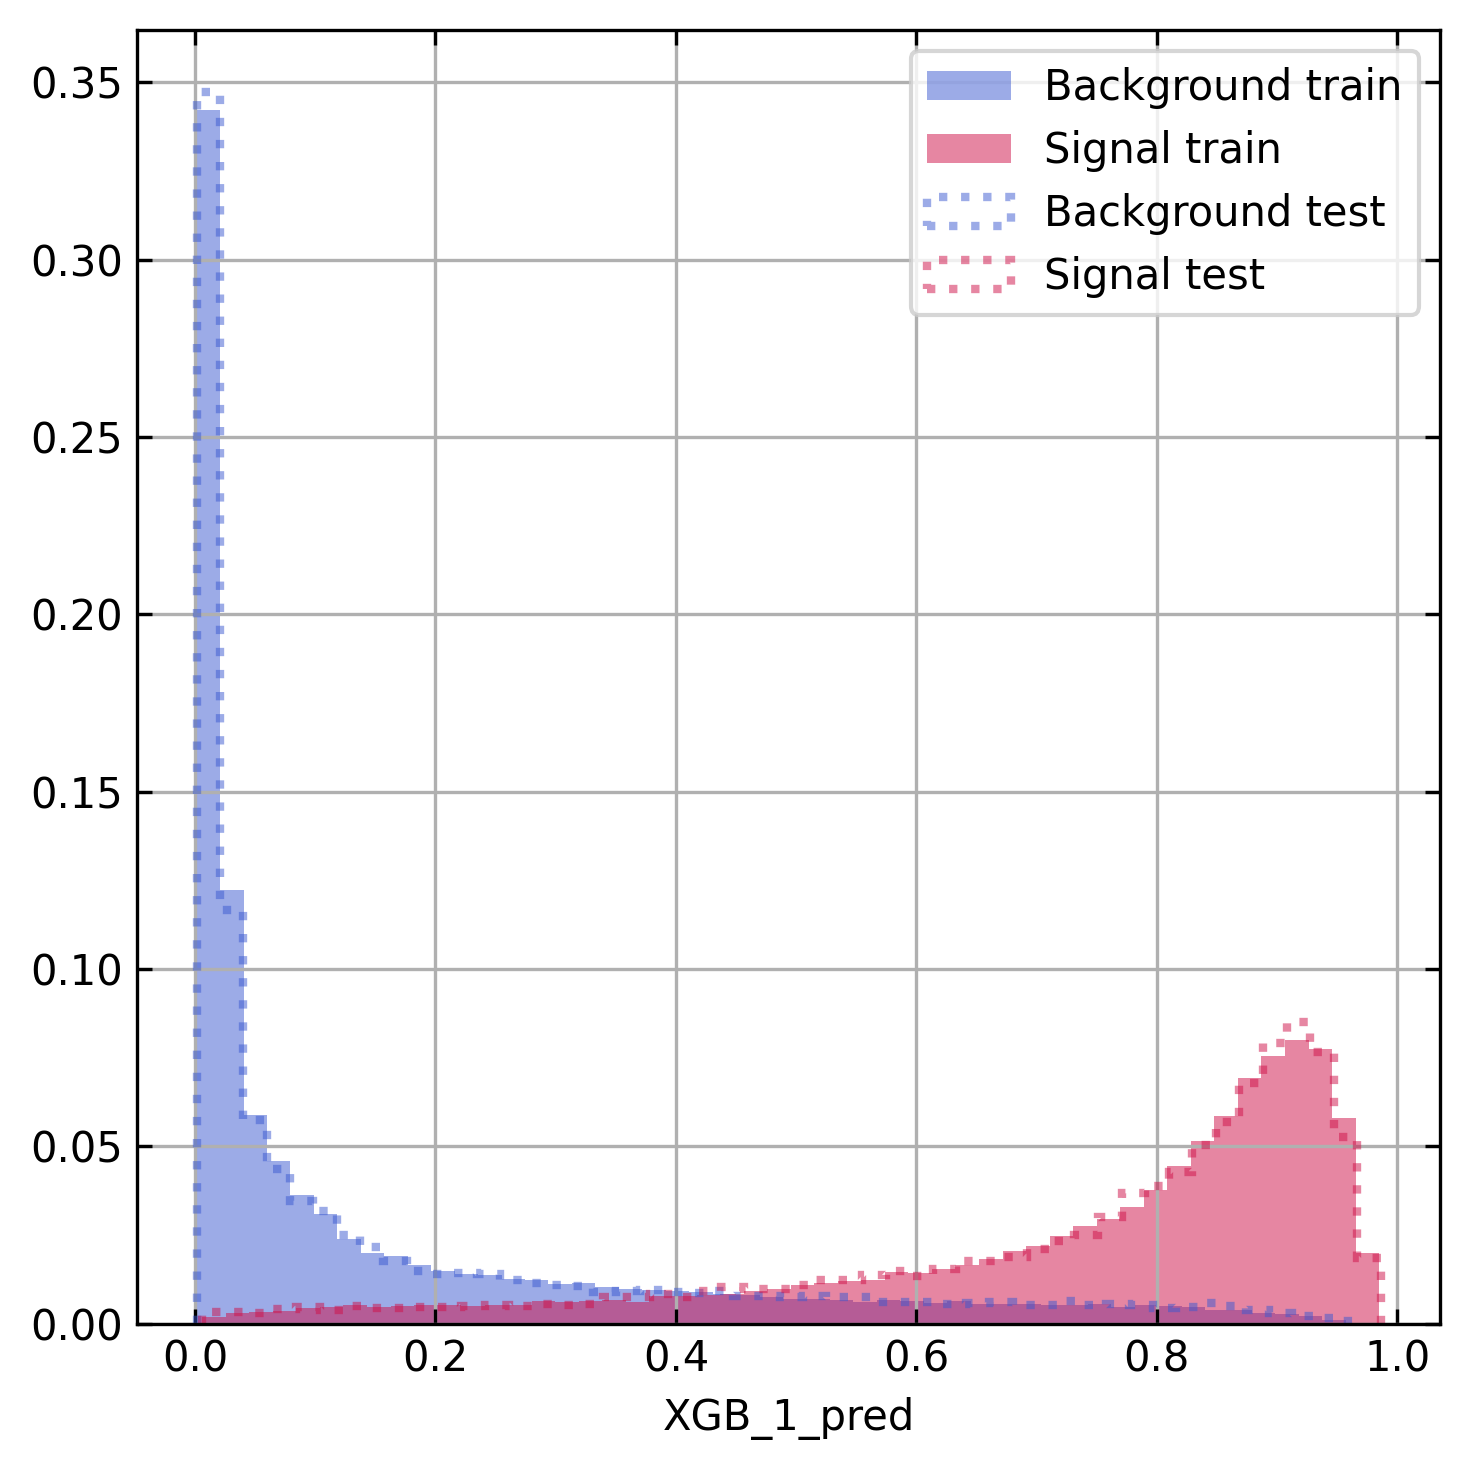

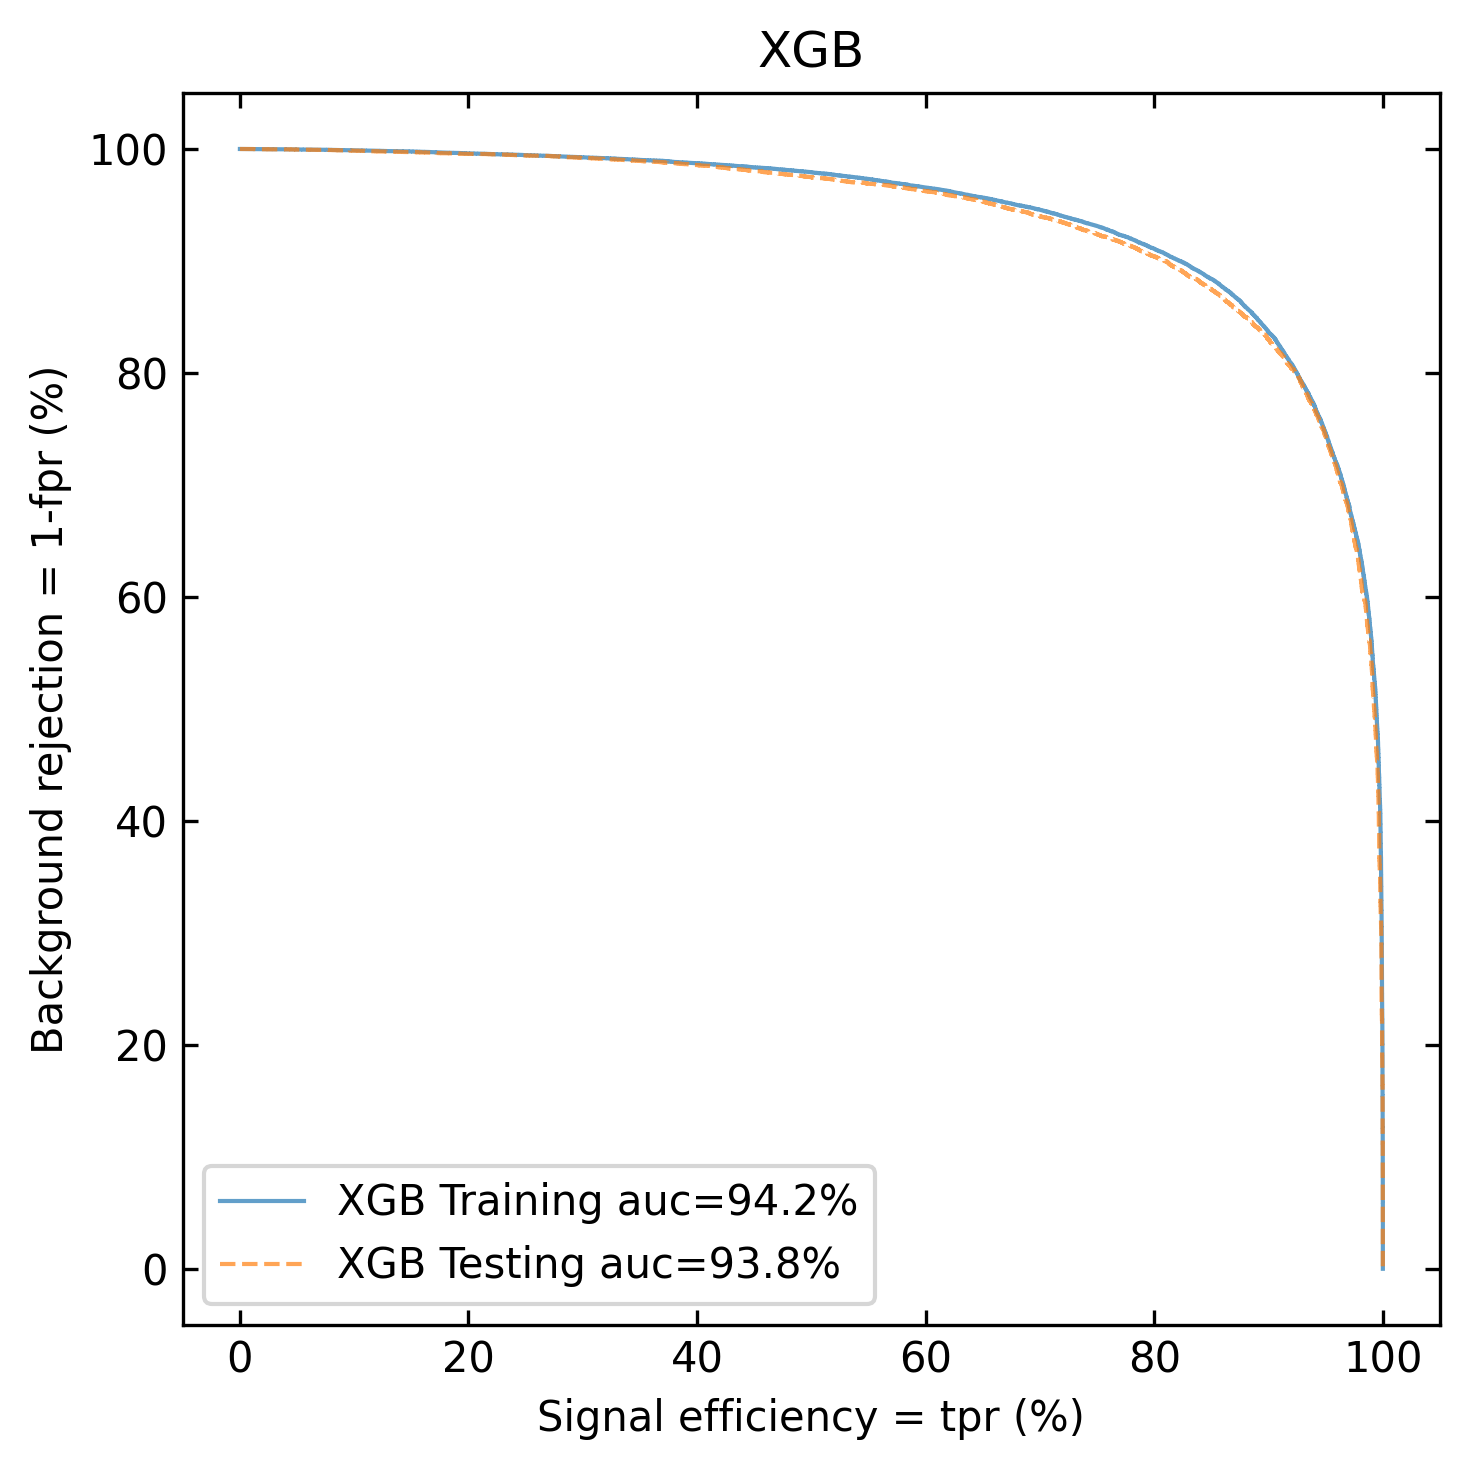

In [13]:
import pickle
import multiprocessing

for MVA in Conf.MVAs:
    if 'XGB' in MVA:
        MakeFeaturePlotsROOT(df_final, Conf.features[MVA], Conf.FeatureBins, Set="Train", MVA=MVA, OutputDirName=Conf.OutputDirName, cat=Conf.Category, label=["Background","Signal"],weight="weight")
        
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,Conf.features[MVA],cat=Conf.Category,weight="weight")
        
        prGreen(MVA+" Training starting")
        import xgboost as xgb
        from sklearn.model_selection import cross_val_score, GridSearchCV
        import ROOT
        
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=Conf.RandomState)
        #xgb_model.set_config(verbosity=2)
        prGreen("Performing XGB grid search")
        if Conf.Multicore:
            cv = GridSearchCV(xgb_model, Conf.XGBGridSearch[MVA],
                              scoring='neg_log_loss',cv=3,verbose=1,n_jobs=2) #multiprocessing.cpu_count())
        else:
            cv = GridSearchCV(xgb_model, Conf.XGBGridSearch[MVA],
                              scoring='neg_log_loss',cv=3,verbose=1)
        search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=1)
        pickle.dump(cv, open(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"modelXGB.pkl", "wb"))

        # Save model in TMVA format
        # Reference: https://root.cern/doc/master/tmva101__Training_8py.html
        ROOT.TMVA.Experimental.SaveXGBoost(search.best_estimator_, "BDT", Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"modelXGB_tmva.root", num_inputs=X_train.shape[1])

        prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
        prGreen("Expected accuracy of XGB model = "+str((np.average(search.best_score_))*100)+'%')
        prGreen("XGB Best Parameters")
    
        prGreen(str(search.best_params_))

        df_final.loc[TrainIndices,MVA+"_pred"]=cv.predict_proba(X_train)[:,1]
        df_final.loc[TestIndices,MVA+"_pred"]=cv.predict_proba(X_test)[:,1]
    
        prGreen("Plotting output response for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_mva(df_final.query('TrainDataset==1'),MVA+"_pred",bins=50,cat=Conf.Category,Wt="weight",ax=axes,sample='train',ls='dashed',logscale=Conf.MVAlogplot,Classes=['Background','Signal'],Colors=['#3A59D1','#CF0F47'])
        plot_mva(df_final.query('TrainDataset==0'),MVA+"_pred",bins=50,cat=Conf.Category,Wt="weight",ax=axes,sample='test',ls='dotted',logscale=Conf.MVAlogplot,Classes=['Background','Signal'],Colors=['#3A59D1','#CF0F47'])
        plt.tight_layout()
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBMVA.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBMVA.png")
    
        prGreen("Plotting ROC for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_roc_curve(df_final.query('TrainDataset==1'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label=Conf.MVALabels[MVA]+' Training',cat=Conf.Category,Wt="weight")
        plot_roc_curve(df_final.query('TrainDataset==0'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label=Conf.MVALabels[MVA]+' Testing',cat=Conf.Category,Wt="weight")
        
        axes.set_ylabel("Background rejection = 1-fpr (%)")
        axes.set_xlabel("Signal efficiency = tpr (%)")
        axes.set_title("XGB")
        axes.text(1.05, 0.5, '',
            horizontalalignment='center',
            verticalalignment='center',
            rotation='vertical',
            transform=axes.transAxes)
        plt.tight_layout()
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBROC.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBROC.png")

## Load the XGBoost model using TMVA

In [14]:
Value_t = ROOT.TMVA.Experimental.RBDT.Value_t
FloatVec = ROOT.std.vector[Value_t]

def predict_batch(model, X):
    X_np = X.to_numpy(dtype=np.float32) if isinstance(X, pd.DataFrame) else X.astype(np.float32)
    preds = []
    for row in X_np:
        vec = FloatVec()
        for val in row:
            vec.push_back(Value_t(val))
        y_vec = model.Compute(vec)
        y = float(y_vec[0])
        preds.append(y)
    return np.array(preds)


ModelFile=Conf.OutputDirName+"/XGB_1/XGB_1_modelXGB_tmva.root"

model = ROOT.TMVA.Experimental.RBDT("BDT", ModelFile)

y_pred_train = predict_batch(model, X_train)
y_pred_test = predict_batch(model, X_test)

/tmp/ipykernel_2532269/65596566.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


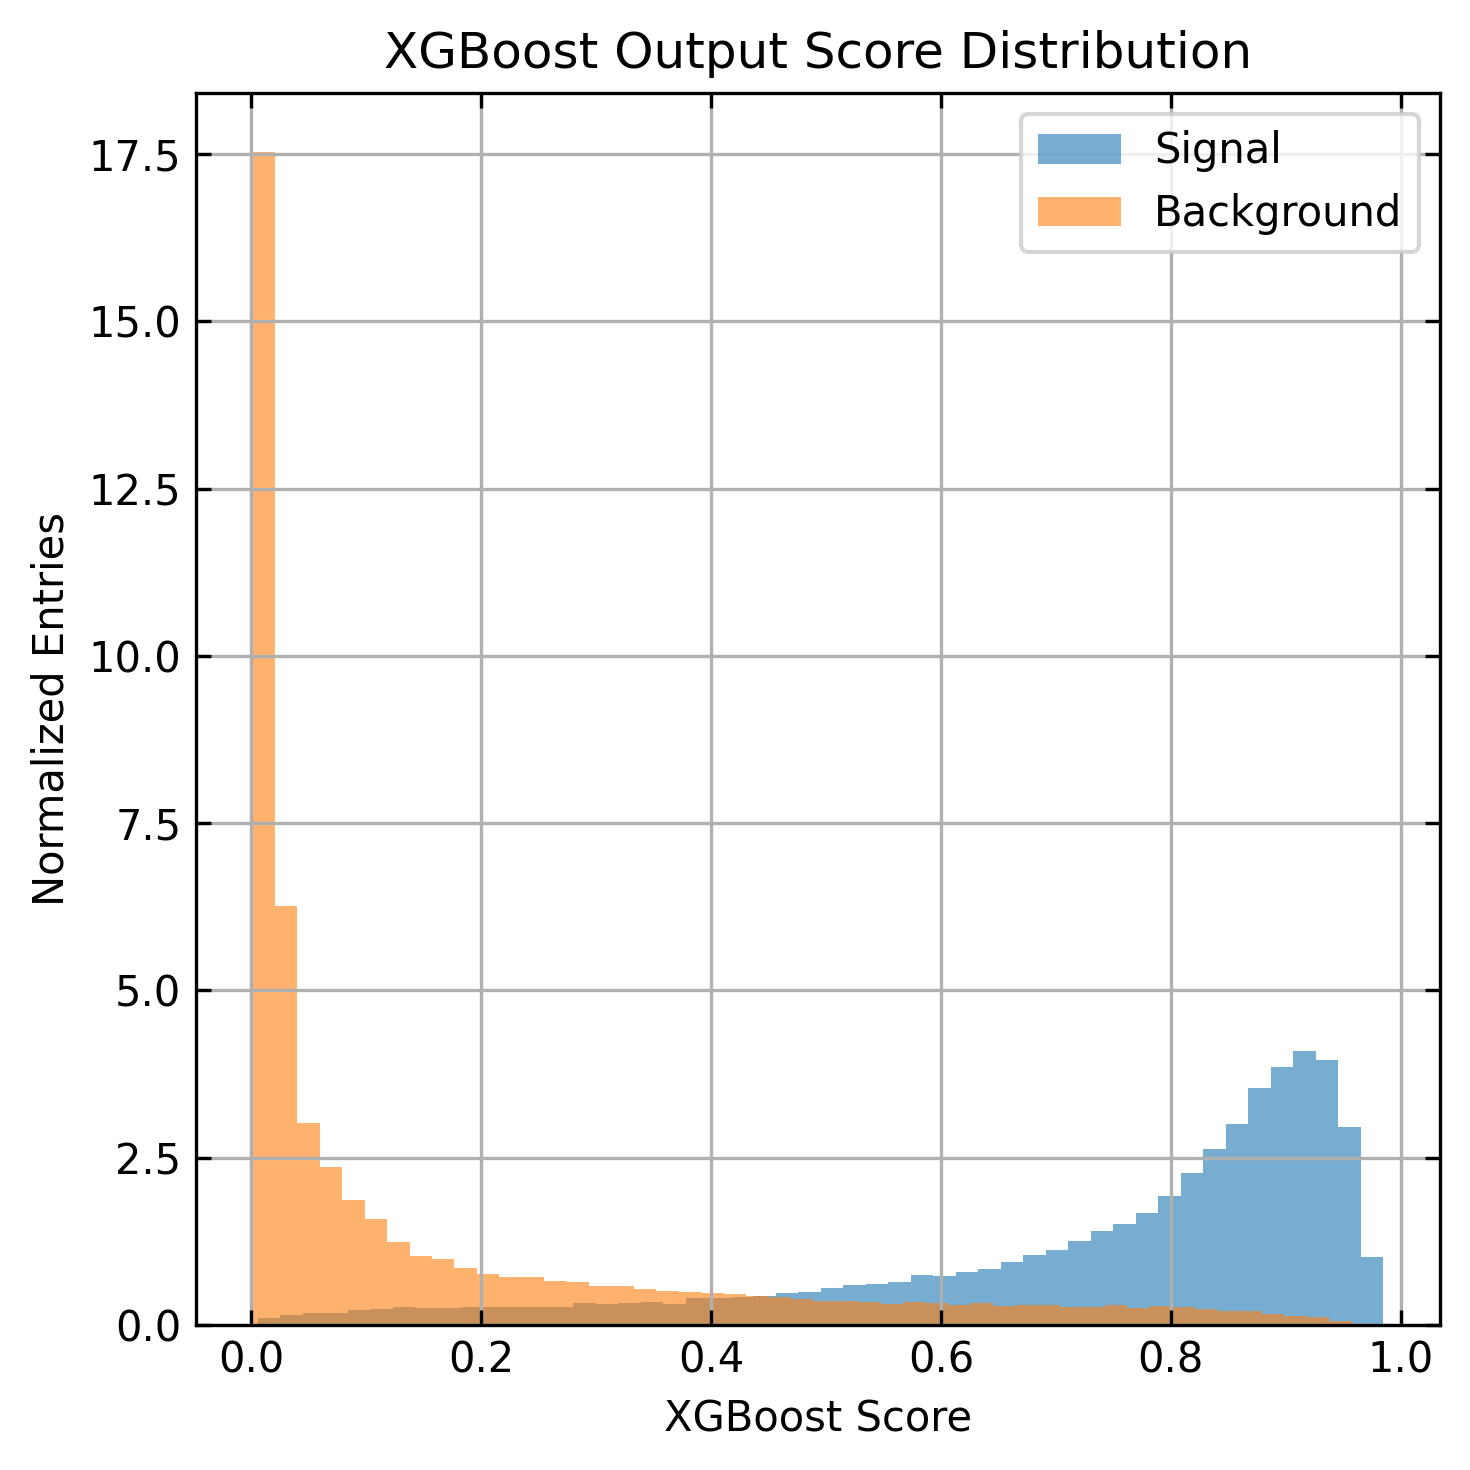

In [15]:
y_pred_signal = y_pred_train[Y_train == 1]
y_pred_bkg = y_pred_train[Y_train == 0]

plt.figure(figsize=(5, 5))
plt.hist(y_pred_signal, bins=50, alpha=0.6, label="Signal", density=True, histtype='stepfilled')
plt.hist(y_pred_bkg, bins=50, alpha=0.6, label="Background", density=True, histtype='stepfilled')

plt.xlabel("XGBoost Score")
plt.ylabel("Normalized Entries")
plt.title("XGBoost Output Score Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()